In [ ]:
# borrows heavily from: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import shutil
import re
import os
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.0.0+cu118
Torchvision Version:  0.15.1+cu118


In [ ]:
# Top level data directory. Here we assume the format of the directory conforms
# to the ImageFolder structure
data_dir = "/content/drive/Shareddrives/CV_videos/Images_from_videos/analysis_split"
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 14 # NUMBER OF CLASSES THAT I PICK

# Batch size for training (change depending on how much memory you have)
batch_size = 32 # BATCH SIZE

# Number of epochs to train for
num_epochs = 5 # EPOCHS

learning_rate = 0.001

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True # UPDATE ONLY LAST LAYER

In [ ]:
def delete_subdirs(root_dir, subdir_name):
    """
    Recursively deletes all subdirectories with name `subdir_name`
    in the directory tree rooted at `root_dir`.
    """
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for dirname in dirnames:
            if dirname == subdir_name:
                subdir_path = os.path.join(dirpath, dirname)
                print(f"Deleting directory {subdir_path}")
                try:
                    os.rmdir(subdir_path)
                except OSError:
                    print(f"Failed to delete {subdir_path}")

delete_subdirs(data_dir, ".ipynb_checkpoints")

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False, scheduler=None):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            if phase == 'val' and scheduler is not None:
              lr = optimizer.param_groups[0].get('lr')
              print('{} Loss: {:.4f} Acc: {:.4f} LR: {}'.format(phase, epoch_loss, epoch_acc, lr))
              scheduler.step(epoch_loss)
            else:
              print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
# print a given model: [resnet, alexnet, vgg, squeezenet, densenet, inception]
# model_used = models.vgg16()
# print(model_used)
# model_used.classifier[6] = nn.Linear(4096, num_classes)
# print(model_used)

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet152
        """
        model_ft = models.resnet152(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg19_bn(pretrained=use_pretrained) #maybe take vgg16?
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size


# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
# print(model_ft)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 160MB/s]


In [ ]:
import os

def count_files(root_dir):
    count = 0
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for f in filenames:
          if '.png' not in f:
            print(f)
        count += len(filenames)
    return count

root_dir = '/content/drive/Shareddrives/CV_videos/Images_from_json/analysis_split/test'
num_files = count_files(root_dir)
print(f'Number of files in subtree: {num_files}')


Number of files in subtree: 6431


In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # BE CAREFUL WHAT SHOULD THIS BE
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # BE CAREFUL WHAT SHOULD THIS BE
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # BE CAREFUL WHAT SHOULD THIS BE
    ]),
}

print("Initializing Datasets and Dataloaders...")

Initializing Datasets and Dataloaders...


In [ ]:
def exclude_ipynb_checkpoints(folder_path):
    return ".ipynb_checkpoints" not in folder_path

In [ ]:
# Create training and validation datasets here:

# REQUIRED FORM: DICTIONARY CONTAINING 
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x], is_valid_file=exclude_ipynb_checkpoints) for x in ['train', 'val', 'test']}
print(image_datasets["train"], len(image_datasets["train"]))

Dataset ImageFolder
    Number of datapoints: 16542
    Root location: /content/drive/Shareddrives/CV_videos/Images_from_videos/analysis_split/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ) 16542


In [ ]:
# Create training, validation, test dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}

In [ ]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()

print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.AdamW(params_to_update, lr=0.0001)
scheduler_ft = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, 'min', factor=0.5, patience=4, threshold=0.001)


Params to learn:
	 fc.weight
	 fc.bias


In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(
    model_ft,
    dataloaders_dict,
    criterion,
    optimizer_ft,
    num_epochs=num_epochs,
    is_inception=(model_name=="inception"),
    scheduler=scheduler_ft)

Epoch 0/4
----------
train Loss: 0.6399 Acc: 0.7954
val Loss: 0.8651 Acc: 0.7275 LR: 6.25e-05

Epoch 1/4
----------
train Loss: 0.6393 Acc: 0.7992
val Loss: 0.8619 Acc: 0.7265 LR: 6.25e-05

Epoch 2/4
----------
train Loss: 0.6380 Acc: 0.7984
val Loss: 0.8582 Acc: 0.7291 LR: 6.25e-05

Epoch 3/4
----------
train Loss: 0.6384 Acc: 0.7953
val Loss: 0.8591 Acc: 0.7242 LR: 3.125e-05

Epoch 4/4
----------
train Loss: 0.6326 Acc: 0.8005
val Loss: 0.8609 Acc: 0.7252 LR: 3.125e-05

Training complete in 16m 7s
Best val Acc: 0.729112


In [ ]:
trained_model_name = str(model_name) + "_b" + str(batch_size) + "_ep" + str(num_epochs) + "_lr" + str(learning_rate) + "_scheduling_cont2"
FOLDER_NAME = "drive/Shareddrives/CV_videos/results_training_NN/Subsampled_images/" + trained_model_name

if not os.path.isdir(FOLDER_NAME):
    os.mkdir(FOLDER_NAME)

In [ ]:
PATH_TO_SAVE_CLREPORT = FOLDER_NAME + "/classification_report.csv"
PATH_TO_SAVE_VALACCURACY = FOLDER_NAME + "/validation_accuracy_per_epoch.csv"
PATH_TO_SAVE_TESTACC = FOLDER_NAME + "/final_test_accuarcy.csv"
PATH_TO_SAVE_CONFUSION = FOLDER_NAME + "/confusion_matrix.csv"

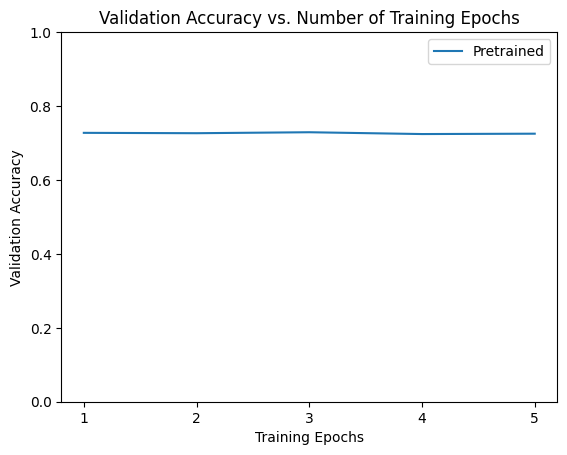

In [ ]:
ohist = []
ohist = [h.cpu().numpy() for h in hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

np.savetxt(PATH_TO_SAVE_VALACCURACY, ohist, delimiter=",")

In [ ]:
print("Max:", max(ohist))


Max: 0.72911227154047


Test set: Average loss: 0.8679, Accuracy: 4838/6617 (73.11%)



(0.867938604701839, 0.7311470454888922)

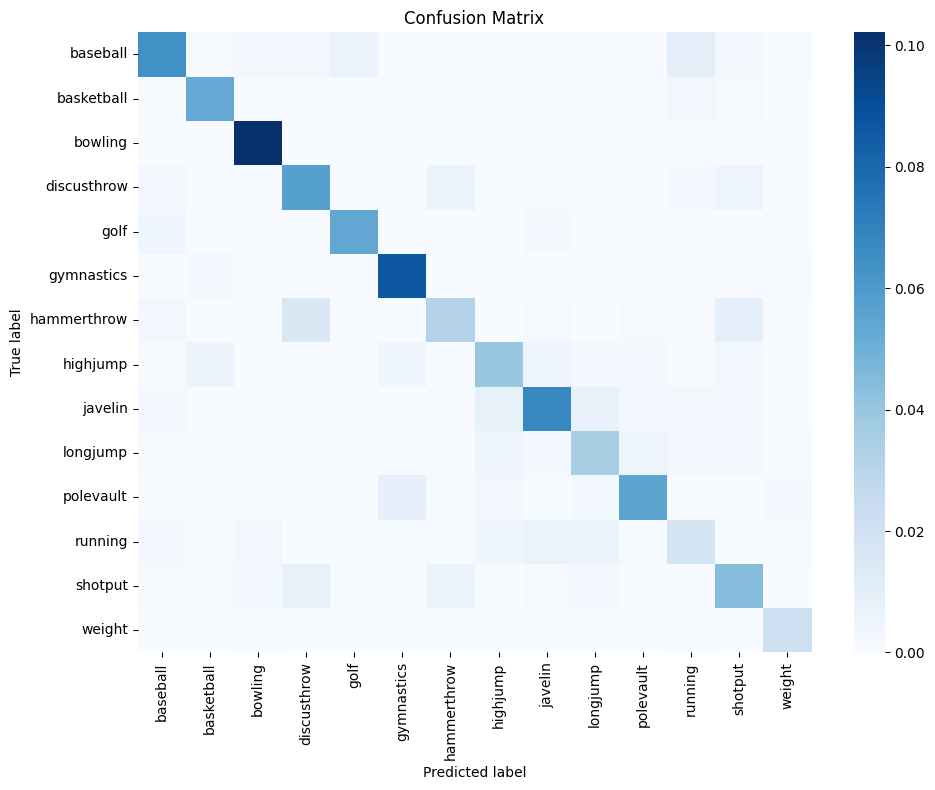

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


def evaluate(model, dataloader, loss_fn, device):
    # Set the model to evaluation mode
    model.eval()
    
    # Initialize variables for tracking the loss and accuracy
    total_loss = 0
    correct = 0
    total = 0
    
    all_pred = []
    all_true = []

    # Disable gradient computations for efficiency
    with torch.no_grad():
        # Loop through the data in the dataloader
        for batch_idx, (data, target) in enumerate(dataloader):
            # Move the data and target tensors to the device
            data, target = data.to(device), target.to(device)
            
            # Forward pass the data through the model
            output = model(data)
            
            # Compute the loss between the model's predictions and the target
            loss = loss_fn(output, target)
            
            # Update the total loss
            total_loss += loss.item() * target.size(0)
            
            # Compute the accuracy of the model's predictions
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            all_pred.append(predicted)
            all_true.append(target)
    
    # Compute the average loss and accuracy over the entire dataset
    avg_loss = total_loss / total
    accuracy = correct / total
        
    y_all_pred = torch.cat(all_pred).cpu().numpy()
    y_all_true = torch.cat(all_true).cpu().numpy()

    class_labels = ['baseball', 'basketball', 'bowling', 'discusthrow', 'golf', 'gymnastics', 'hammerthrow', 'highjump', 'javelin', 'longjump', 'polevault', 'running', 'shotput', 'weight']

    # Compute the confusion matrix
    cm = confusion_matrix(y_true=y_all_true, y_pred=y_all_pred, normalize='all', labels=None)
    np.savetxt(PATH_TO_SAVE_CONFUSION, cm, delimiter=",")

    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(cm, annot=False, cmap='Blues', fmt='.3f', xticklabels=class_labels, yticklabels=class_labels, ax=ax)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title('Confusion Matrix')
    plt.tight_layout()

    # Save the plot to a file
    fig.savefig(PATH_TO_SAVE_CONFUSION + ".png")


    clsf_report = pd.DataFrame(classification_report(y_true = y_all_true, y_pred = y_all_pred, output_dict=True, target_names=class_labels)).transpose()
    clsf_report.to_csv(PATH_TO_SAVE_CLREPORT, index= True)

    # Print the results
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        avg_loss, correct, total, 100. * accuracy))
    
    return avg_loss, accuracy

avg_loss, accuracy = evaluate(model_ft, dataloaders_dict["test"], criterion, "cuda")
avg_loss, accuracy

In [ ]:
test_accuracy = pd.DataFrame([[accuracy]]).transpose()
test_accuracy.to_csv(PATH_TO_SAVE_TESTACC)

# Results - 5 pictures per video
- Resnet large 0.7094 test accuracy
- Resnet large (larger LR) 0.7294 test accuracy
- Resnet large (LR scheduling) - 0.7344
- VGG large (LR scheduling) - 0.70888